In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preparation

Data source: https://www.kaggle.com/ueslei/ucs-satellite-database

In [2]:
df = pd.read_csv('./ucs-satellite-database/UCS_Satellite_Database_12-1-2018-1.csv',
    engine='python', decimal=',', thousands='.', parse_dates=['Date of Launch'], dayfirst=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 65 columns):
Name of Satellite, Alternate Names    1957 non-null object
Country/Org of UN Registry            1957 non-null object
Country of Operator/Owner             1957 non-null object
Operator/Owner                        1957 non-null object
Users                                 1957 non-null object
Purpose                               1957 non-null object
Detailed Purpose                      720 non-null object
Class of Orbit                        1955 non-null object
Type of Orbit                         1348 non-null object
Longitude of GEO (degrees)            1956 non-null object
Perigee (km)                          1957 non-null float64
Apogee (km)                           1957 non-null int64
Eccentricity                          1957 non-null object
Inclination (degrees)                 1957 non-null object
Period (minutes)                      1957 non-null float64
Launch M

In [4]:
# Drop some unnecessary columns
cat_cols = ['Users', 'Class of Orbit']
num_cols = ['Perigee (km)', 'Apogee (km)', 'Period (minutes)', 'Launch Mass (kg.)']

df.drop(df.columns.difference(cat_cols + num_cols), axis=1, inplace=True)

# Individual columns

Categorical columns:
- Users
- Class of orbit

Numerical columns:
- Perigee
- Apogee
- Period
- Launch mass

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 6 columns):
Users                1957 non-null object
Class of Orbit       1955 non-null object
Perigee (km)         1957 non-null float64
Apogee (km)          1957 non-null int64
Period (minutes)     1957 non-null float64
Launch Mass (kg.)    1813 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 91.9+ KB


## Basic statistics

In [6]:
# Numerical column statistics
df.describe()

,Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.)
count,1957.000000,1957.000000,1957.000000,1813.000000
mean,10790.257537,12176.452734,547.584384,686.922819
std,15289.689511,19568.255206,654.771477,1370.784934
min,0.000000,1.000000,90.520000,1.000000
25%,499.000000,534.000000,95.230000,10.000000
50%,696.000000,774.000000,99.800000,90.000000
75%,35549.000000,35787.000000,1436.010000,689.000000
max,49551.000000,268679.000000,8758.000000,7075.000000


### Categorical variables

In [7]:
users_count = df.groupby('Users')['Users'].agg(['count']).reset_index()
users_count.sort_values('count', ascending=False, inplace=True)
users_count

,Users,count
2,Commercial,845
5,Government,384
11,Military,301
0,Civil,143
7,Government/Commercial,121
14,Military/Commercial,72
15,Military/Government,45
6,Government/Civil,28
9,Government/Military,5
13,Military/Civil,3


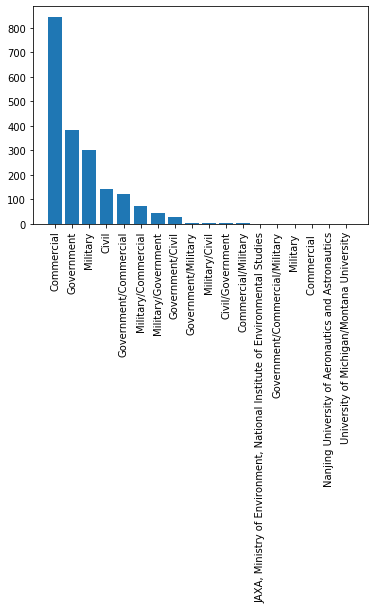

In [8]:
plt.bar(users_count['Users'], users_count['count'])
plt.xticks(rotation='vertical')
plt.show()

In [9]:
# Assigning some less-important categories a single name
main_cats = ['Commercial', 'Government', 'Military', 'Civil']
df['Users'] = df['Users'].apply(lambda x: x if x in main_cats else 'Mixed')

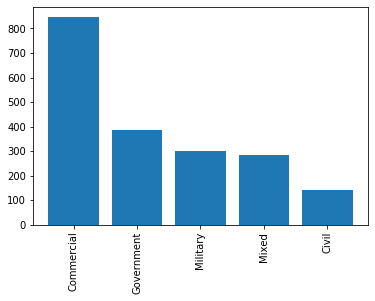

In [10]:
users_count2 = df.groupby('Users')['Users'].agg(['count']).reset_index()
users_count2.sort_values('count', ascending=False, inplace=True)
plt.bar(users_count2['Users'], users_count2['count'])
plt.xticks(rotation='vertical')
plt.show()

In [11]:
orbit_class_count = df.groupby('Class of Orbit')['Class of Orbit'].agg(['count']).reset_index()
orbit_class_count.sort_values('count', ascending=False, inplace=True)
orbit_class_count

,Class of Orbit,count
3,LEO,1227
2,GEO,558
4,MEO,124
1,Elliptical,45
0,Earth Science,1


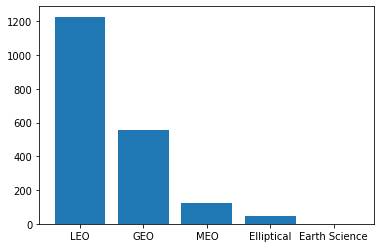

In [12]:
plt.bar(orbit_class_count['Class of Orbit'], orbit_class_count['count'])
plt.show()

### Numerical variables

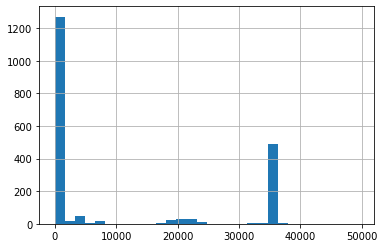

In [13]:
df['Perigee (km)'].hist(bins=30)

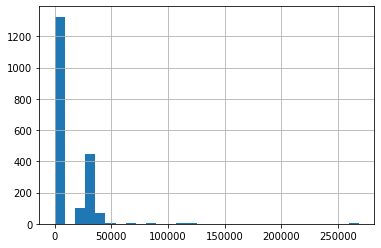

In [14]:
df['Apogee (km)'].hist(bins=30)

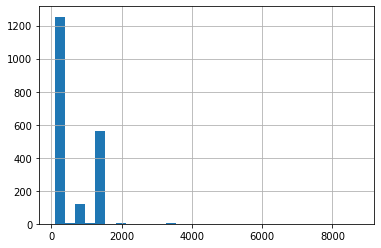

In [15]:
df['Period (minutes)'].hist(bins=30)

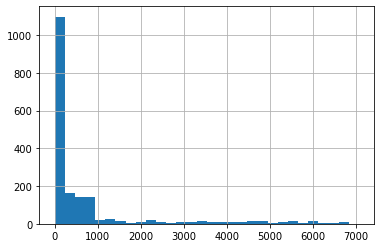

In [16]:
df['Launch Mass (kg.)'].hist(bins=30)

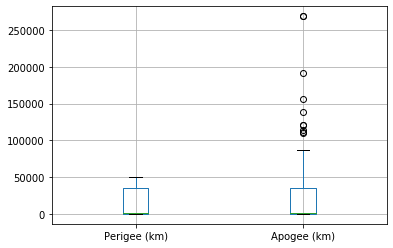

In [17]:
df.boxplot(column=['Perigee (km)', 'Apogee (km)'])
plt.show()

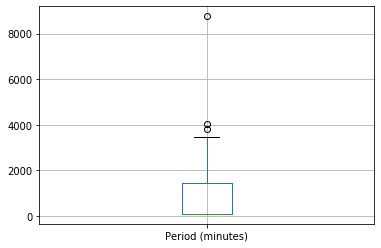

In [18]:
df.boxplot(column=['Period (minutes)'])
plt.show()

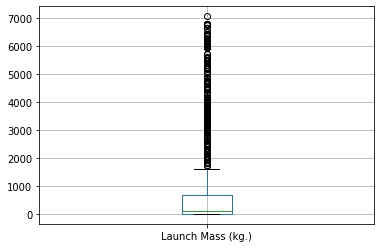

In [19]:
df.boxplot(column=['Launch Mass (kg.)'])
plt.show()

## Outliers

In [20]:
# Determine outliers using interquartile range (IQR)
q1 = df.quantile(0.25)
q1

Perigee (km)         499.00
Apogee (km)          534.00
Period (minutes)      95.23
Launch Mass (kg.)     10.00
Name: 0.25, dtype: float64

In [21]:
q3 = df.quantile(0.75)
q3

Perigee (km)         35549.00
Apogee (km)          35787.00
Period (minutes)      1436.01
Launch Mass (kg.)      689.00
Name: 0.75, dtype: float64

In [22]:
iqr = q3 - q1
iqr

Perigee (km)         35050.00
Apogee (km)          35253.00
Period (minutes)      1340.78
Launch Mass (kg.)      679.00
dtype: float64

In [23]:
# Boolean series indicating whether the row 
# is considered as outlier (False) or not (True)
non_outliers_iqr = ~((df < (q1 - 1.5 * iqr)) |(df > (q3 + 1.5 * iqr))).any(axis=1)

In [25]:
# Another criteria for selecting outliers
# Satellites usually do not orbit in altitudes below 200 km
non_outliers_alt = ~((df['Apogee (km)'] < 200) | (df['Perigee (km)'] < 200))

In [26]:
non_outliers = non_outliers_iqr & non_outliers_alt

## Missing values

In [27]:
non_missing = ~df['Launch Mass (kg.)'].isnull()
non_missing.describe()

count     1957
unique       2
top       True
freq      1813
Name: Launch Mass (kg.), dtype: object

# Column combinations

In [28]:
# Covariance
df.cov()

,Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.)
Perigee (km),2.337746e+08,2.069328e+08,8.355546e+06,8.712795e+06
Apogee (km),2.069328e+08,3.829166e+08,1.125415e+07,9.053225e+06
Period (minutes),8.355546e+06,1.125415e+07,4.287257e+05,3.727635e+05
Launch Mass (kg.),8.712795e+06,9.053225e+06,3.727635e+05,1.879051e+06


In [29]:
# Correlation (with outliers)
df.corr()

,Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.)
Perigee (km),1.000000,0.691638,0.834615,0.414086
Apogee (km),0.691638,1.000000,0.878357,0.332113
Period (minutes),0.834615,0.878357,1.000000,0.411438
Launch Mass (kg.),0.414086,0.332113,0.411438,1.000000


In [30]:
# Correlation (without outliers)
df[non_outliers].corr()

,Perigee (km),Apogee (km),Period (minutes),Launch Mass (kg.)
Perigee (km),1.000000,0.854683,0.914264,0.130305
Apogee (km),0.854683,1.000000,0.916935,0.107561
Period (minutes),0.914264,0.916935,1.000000,0.107272
Launch Mass (kg.),0.130305,0.107561,0.107272,1.000000


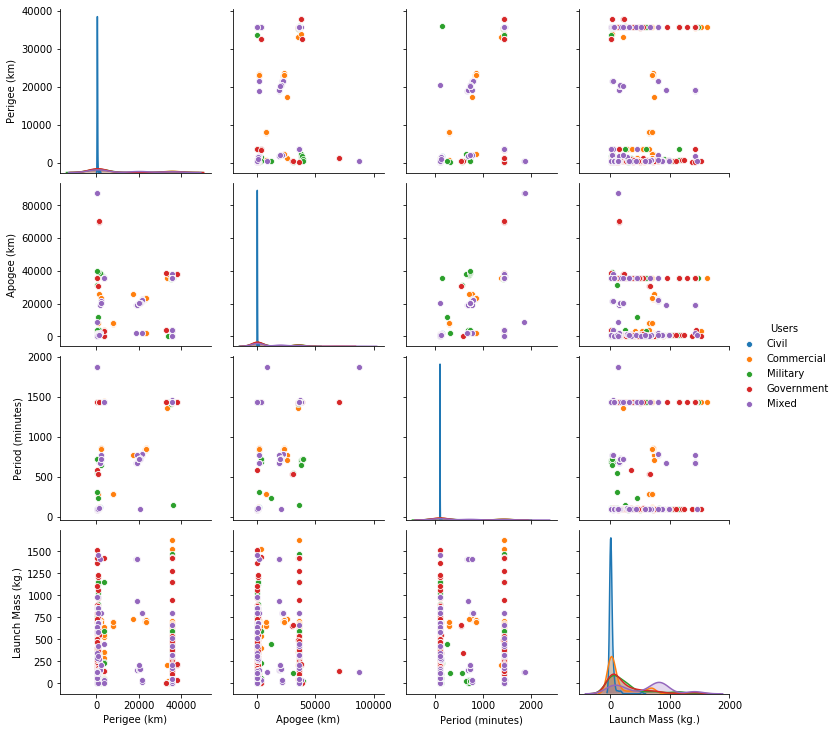

In [31]:
sns.pairplot(df[non_outliers], hue="Users")
plt.show()

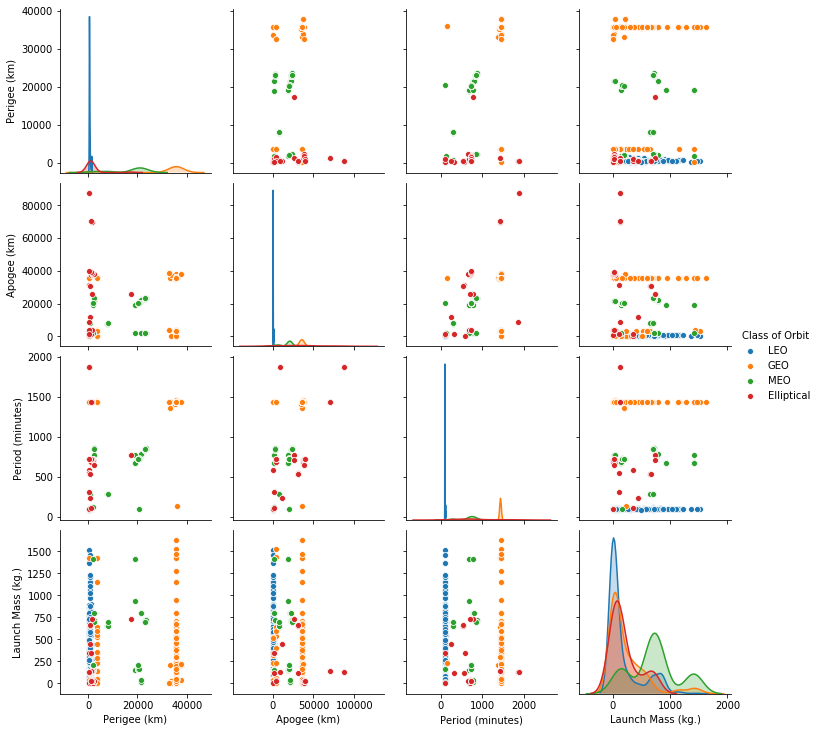

In [32]:
sns.pairplot(df[non_outliers], hue="Class of Orbit")
plt.show()

# PCA

In [33]:
# Use only numerical columns and filter out rows with outliers and missing values
x = df[num_cols][non_outliers & non_missing].values

# Normalize the data
x = StandardScaler().fit_transform(x)

# Do PCA transform
pca = PCA(n_components=2)
df_pca = pd.DataFrame(data=pca.fit_transform(x), columns=['pc1', 'pc2'])

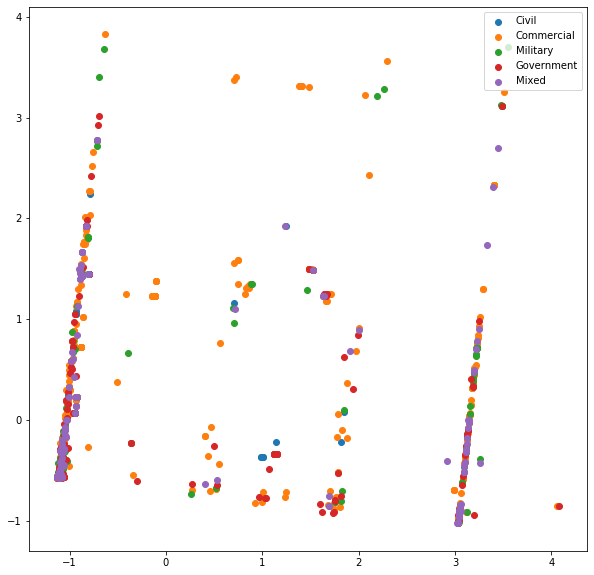

In [34]:
# Plot by users
plt.figure(figsize=(10, 10))
classes = df['Users'].unique().tolist()
for class_ in classes:
    indices = df['Users'] == class_
    plt.scatter(df_pca.loc[indices, 'pc1'],
                df_pca.loc[indices, 'pc2'], label=class_)
plt.legend()

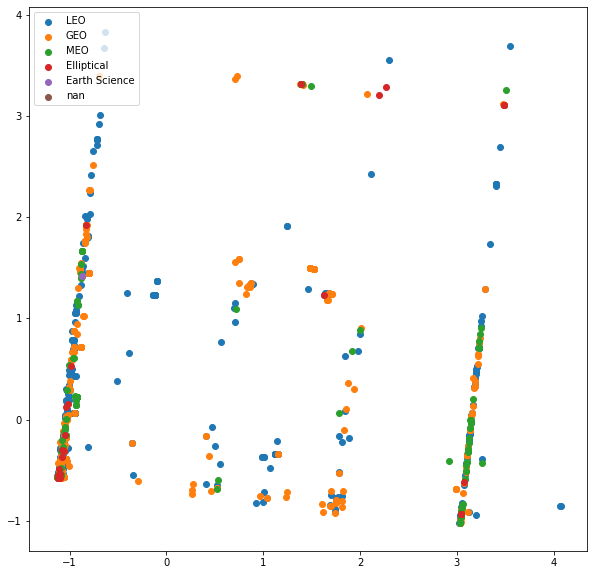

In [35]:
# Plot by orbit class
plt.figure(figsize=(10, 10))
classes = df['Class of Orbit'].unique().tolist()
for class_ in classes:
    indices = df['Class of Orbit'] == class_
    plt.scatter(df_pca.loc[indices, 'pc1'],
                df_pca.loc[indices, 'pc2'], label=class_)
plt.legend()

# Result interpretation
- How many outliers? (percentage)
- Linear dependencies between variables?
- Class separation?
- Which 3 main conclusions can be stated in domain terms?